<a href="https://colab.research.google.com/github/fikran03/Kelompok_Boboiboy_Halilintar_NLP_Hewan_Laut/blob/main/HewanLautNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving dataset.pdf to dataset.pdf


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Masukkan pertanyaan Anda: Hewan laut yang dilindungi di Papua?


Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error dengan model indobenchmark: not a string
Menggunakan model alternatif xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Jawaban yang dihasilkan: Dugong
BERTScore Precision: 0.63
BERTScore Recall: 0.44
BERTScore F1: 0.52


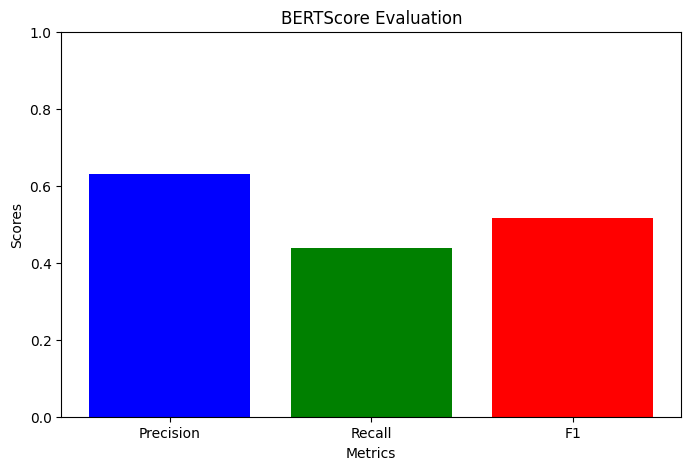

In [31]:
import fitz  # PyMuPDF
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import pipeline
from bert_score import score
import matplotlib.pyplot as plt

# Fungsi untuk mengekstrak teks dari PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

# Mengunggah file PDF (gunakan metode yang sesuai jika di Colab)
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

# Mengekstrak teks dari PDF
text = extract_text_from_pdf(pdf_path)

# Membagi teks menjadi halaman untuk dimasukkan ke FAISS
pages = [{"page_content": page} for page in text.split("\n\n")]

# Menginisialisasi model sentence-transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Mendapatkan embeddings untuk setiap halaman
embeddings = model.encode([page['page_content'] for page in pages])

# Fungsi untuk melakukan pencarian kesamaan
def similarity_search(query, embeddings, pages, model, top_k=5):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return [pages[i] for i in top_k_indices]

# Melakukan pencarian kesamaan
query = input("Masukkan pertanyaan Anda: ")
docs = similarity_search(query, embeddings, pages, model)

# Menggabungkan konten yang relevan
content = "\n".join([x["page_content"] for x in docs])

# Menggunakan pipeline QA Hugging Face
try:
    qa_model = pipeline("question-answering", model="indobenchmark/indobert-lite-large-p2", tokenizer="indobenchmark/indobert-lite-large-p2")
except Exception as e:
    print(f"Error dengan model indobenchmark: {e}")
    print("Menggunakan model alternatif xlm-roberta-base")
    qa_model = pipeline("question-answering", model="xlm-roberta-base", tokenizer="xlm-roberta-base")

# Melakukan inferensi
qa_input = {"question": query, "context": content}
result = qa_model(qa_input)
generated_answer = result['answer']

# Menampilkan jawaban yang dihasilkan
print("Jawaban yang dihasilkan:", generated_answer)

# Jawaban referensi (ganti ini dengan jawaban yang benar untuk evaluasi)
reference_answer = "Perairan Papua memiliki keanekaragaman hayati laut yang luar biasa, mencakup berbagai jenis ikan, penyu, mamalia laut, hiu, invertebrata, dan crustacea. Beberapa ikan yang menonjol termasuk ikan Napoleon (Cheilinus undulatus) yang terancam dan dilindungi, serta ikan pari manta (Manta birostris) dan berbagai spesies kerapu yang penting bagi ekosistem terumbu karang dan perikanan lokal. Penyu laut seperti penyu hijau (Chelonia mydas), penyu sisik (Eretmochelys imbricata), dan penyu lekang (Lepidochelys olivacea) sering ditemukan di perairan ini, berperan penting dalam menjaga keseimbangan ekosistem laut. Mamalia laut seperti dugong (Dugong dugon), yang dikenal juga sebagai sapi laut, serta berbagai spesies lumba-lumba, termasuk lumba-lumba hidung botol (Tursiops truncatus), juga menghuni perairan Papua. Hiu paus (Rhincodon typus), ikan terbesar di dunia, sering terlihat di perairan Papua, bersama dengan berbagai spesies hiu karang yang hidup di sekitar terumbu karang. Invertebrata laut, termasuk terumbu karang yang merupakan salah satu ekosistem terkaya di dunia, moluska seperti kerang, siput laut, dan cumi-cumi, serta crustacea seperti kepiting kelapa (Birgus latro) dan udang karang, juga berkontribusi pada keanekaragaman hayati laut di wilayah ini. Selain itu, ekosistem alami seperti hutan mangrove dan padang lamun menyediakan habitat penting bagi banyak spesies laut, termasuk dugong dan penyu laut. Perlindungan dan konservasi keanekaragaman hayati laut di Papua sangat penting untuk memastikan kelangsungan hidup spesies ini dan kesehatan ekosistem laut secara keseluruhan."
if reference_answer:
    # Menghitung BERTScore
    P, R, F1 = score([generated_answer], [reference_answer], lang="id")

    # Menyederhanakan output menjadi dua tempat desimal
    P_mean = P.mean().item()
    R_mean = R.mean().item()
    F1_mean = F1.mean().item()

    print(f"BERTScore Precision: {P_mean:.2f}")
    print(f"BERTScore Recall: {R_mean:.2f}")
    print(f"BERTScore F1: {F1_mean:.2f}")

    # Plot hasil BERTScore
    scores = [P_mean, R_mean, F1_mean]
    labels = ['Precision', 'Recall', 'F1']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, scores, color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('BERTScore Evaluation')
    plt.show()
else:
    print("Tidak ada jawaban referensi yang dimasukkan. Evaluasi BERTScore tidak dilakukan.")
